# Week 2 — Two-View Reconstruction

- Intrinsic matrix construction (K) consistent with resized images
- Essential matrix estimation with RANSAC
- Decomposition into four pose candidates and cheirality-based disambiguation
- Triangulation of 3D points and PLY export
- Open3D visualization



In [3]:
"""
Integrated two-view SfM pipeline (patched)

- Integrates symmetric matching (mutual check + Lowe ratio)
- Uses Essential -> fallback to Fundamental when needed
- Triangulates and filters points by reprojection error, parallax and positive depth
- Clamps depth outliers
- Optional auto-scan for best initialization pair
- Saves PLY and visualizes using Open3D (if available)

Usage:
    edit the `images_folder`, idx0, idx1 variables near the bottom and run.
    Or set idx0, idx1 = None, None to auto-scan best initial pair.

Author: patched and integrated for your notebook
"""
import os
import glob
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

# open3d optional
try:
    import open3d as o3d
    OPEN3D_AVAILABLE = True
except Exception:
    OPEN3D_AVAILABLE = False

plt.rcParams['figure.dpi'] = 120

# ---------- Utilities (preserved from your original file) ----------
def load_images_from_folder(folder, exts=('jpg','jpeg','png')):
    files = []
    for ext in exts:
        files.extend(sorted(glob.glob(os.path.join(folder, f'*.{ext}'))))
    imgs = [cv2.imread(p) for p in files]
    return imgs, files

def show_image_grid(imgs, cols=5, figsize=(12,6), titles=None):
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=figsize)
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else np.zeros((10,10,3))
        plt.imshow(im)
        plt.axis('off')
        if titles:
            plt.title(titles[i], fontsize=9)
    plt.tight_layout()
    plt.show()

def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ---------- Preprocessing options ----------
PREPROCESS = True
PREPROCESS_SIZE = (1024, 768)
APPLY_CLAHE = False

def preprocess_image(img, size=PREPROCESS_SIZE, clahe=APPLY_CLAHE):
    if img is None:
        return None
    if size is not None:
        img = cv2.resize(img, size)
    if clahe:
        gray = to_gray(img)
        clahe_f = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        eq = clahe_f.apply(gray)
        img = cv2.cvtColor(eq, cv2.COLOR_GRAY2BGR)
    return img

# ---------- Detector & descriptor ----------
def make_detector():
    try:
        sift = cv2.SIFT_create(nfeatures=10000, contrastThreshold=0.05)
        print('Using SIFT')
        return sift, True
    except Exception:
        print('SIFT unavailable; using ORB')
        orb = cv2.ORB_create(5000)
        return orb, False

def detect_and_compute(detector, img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kps, desc = detector.detectAndCompute(gray, None)
    return kps, desc

# ---------- Intrinsics builder (keeps your original fallback) ----------
def make_K_from_image(img):
    h, w = img.shape[:2]
    fx = float(w)
    fy = float(w)
    cx = float(w) / 2.0
    cy = float(h) / 2.0
    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype=np.float64)
    return K

# ---------- Replace match_with_ratio with symmetric matching ----------
def symmetric_match_knn(matcher, desc1, desc2, ratio=0.75):
    """Mutual knn matching with Lowe ratio test — fixed index bookkeeping.
    Returns a list of cv2.DMatch that are mutual best and pass Lowe ratio.
    """
    if desc1 is None or desc2 is None:
        return []

    # A -> B
    knn_ab = matcher.knnMatch(desc1, desc2, k=2)
    good_ab = []
    for pair in knn_ab:
        if len(pair) != 2:
            continue
        m, n = pair
        if m.distance < ratio * n.distance:
            # m.queryIdx is index in desc1, m.trainIdx is index in desc2
            good_ab.append((m.queryIdx, m.trainIdx, m))
    # Build a map for quick lookup of A->B matches: map (idx1 -> idx2)
    ab_map = {(a,b): match_obj for (a,b,match_obj) in good_ab}

    # B -> A
    knn_ba = matcher.knnMatch(desc2, desc1, k=2)
    good_ba = []
    for pair in knn_ba:
        if len(pair) != 2:
            continue
        m, n = pair
        if m.distance < ratio * n.distance:
            # m.queryIdx is index in desc2, m.trainIdx is index in desc1
            good_ba.append((m.trainIdx, m.queryIdx))  # normalized to (idx1, idx2)

    # Keep only those matches that are mutual: (idx1, idx2) exists in both
    symmetric = []
    good_ba_set = set(good_ba)
    for (a,b,match_obj) in good_ab:
        if (a,b) in good_ba_set:
            symmetric.append(match_obj)

    return symmetric


# ---------- Essential estimation with fallback to Fundamental ----------
def estimate_E_with_fallback(pts1, pts2, K, threshold=1.0):
    """Attempt Essential estimation; if unreliable, fall back to Fundamental.
    Returns (E_matrix, boolean_mask)
    """
    if pts1.shape[0] < 8:
        return None, np.zeros((pts1.shape[0],), dtype=bool)
    # Try essential first
    E, maskE = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=threshold)
    if E is not None and maskE is not None:
        n_in = int(np.sum(maskE))
        if n_in >= max(8, int(0.08 * pts1.shape[0])):
            return E, maskE.ravel().astype(bool)
    # Fallback to fundamental
    F, maskF = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1.0, 0.99)
    if F is None or maskF is None:
        return None, np.zeros((pts1.shape[0],), dtype=bool)
    E_from_F = K.T.dot(F).dot(K)
    return E_from_F, maskF.ravel().astype(bool)

# ---------- Triangulation and geometric filtering ----------
def triangulate_and_filter(P1, P2, pts1, pts2, K, max_reproj=5.0, min_parallax_deg=1.0):
    """
    Triangulate and apply filters: positive depth, reprojection, parallax.
    Returns filtered pts3d (N x 3), reproj_errors (N), parallax_degs (N)
    """
    if pts1.shape[0] == 0:
        return np.zeros((0,3)), np.zeros((0,)), np.zeros((0,))
    pts4 = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    pts3 = (pts4[:3] / pts4[3]).T  # N x 3

    if pts3.size == 0:
        return pts3, np.array([]), np.array([])

    z1 = pts3[:,2]
    R2 = P2[:, :3]
    t2 = P2[:, 3]
    X_cam2 = (R2.dot(pts3.T) + t2.reshape(3,1)).T
    z2 = X_cam2[:,2]

    def reproj_errors(P, X, pts2d):
        Xh = np.hstack([X, np.ones((X.shape[0],1))]).T
        proj = P.dot(Xh)
        proj = (proj[:2] / proj[2]).T
        err = np.linalg.norm(proj - pts2d, axis=1)
        return err

    reproj1 = reproj_errors(P1, pts3, pts1)
    reproj2 = reproj_errors(P2, pts3, pts2)
    reproj = np.maximum(reproj1, reproj2)

    Kinv = np.linalg.inv(K)
    ones = np.ones((pts1.shape[0], 1))
    rays1 = (Kinv.dot(np.hstack([pts1, ones]).T)).T
    rays2 = (Kinv.dot(np.hstack([pts2, ones]).T)).T
    norms1 = np.linalg.norm(rays1, axis=1)
    norms2 = np.linalg.norm(rays2, axis=1)
    dots = np.sum(rays1 * rays2, axis=1)
    cosang = dots / (norms1 * norms2 + 1e-12)
    cosang = np.clip(cosang, -1.0, 1.0)
    parallax = np.degrees(np.arccos(cosang))

    mask = (reproj <= max_reproj) & (z1 > 0) & (z2 > 0) & (parallax >= min_parallax_deg)
    return pts3[mask], reproj[mask], parallax[mask]

def clamp_depth_outliers(pts3d, z_factor=4.0):
    if pts3d.shape[0] == 0:
        return pts3d
    z = pts3d[:,2]
    med = np.median(z)
    std = np.std(z)
    cap = med + z_factor * std
    keep = z <= cap
    return pts3d[keep]

# ---------- Keypoint -> numpy helper (kept from your version) ----------
def keypoints_to_np(kps, matches, query=True):
    pts = []
    for m in matches:
        kp = kps[m.queryIdx] if query else kps[m.trainIdx]
        pts.append(kp.pt)
    return np.array(pts, dtype=np.float32)

# ---------- PLY saving (preserved) ----------
def save_ply(points3d, filename, colors=None):
    n = points3d.shape[0]
    with open(filename, 'w') as f:
        f.write('ply\nformat ascii 1.0\n')
        f.write(f'element vertex {n}\n')
        f.write('property float x\nproperty float y\nproperty float z\n')
        if colors is not None:
            f.write('property uchar red\nproperty uchar green\nproperty uchar blue\n')
        f.write('end_header\n')
        for i in range(n):
            x,y,z = points3d[i]
            if colors is None:
                f.write(f'{x} {y} {z}\n')
            else:
                r,g,b = colors[i]
                f.write(f'{x} {y} {z} {int(r)} {int(g)} {int(b)}\n')
    print('Saved PLY:', filename)

# ---------- Auto-scan for best initial pair (optional) ----------
def find_best_initial_pair(imgs, preprocess_fn, make_K_fn, detector_fn, matcher, max_offset=6, ratio=0.75):
    best = (0, 1, -1)
    detector, is_sift = detector_fn()
    for i in range(len(imgs)):
        im_i = preprocess_fn(imgs[i])
        kps_i, desc_i = detect_and_compute(detector, im_i)
        if desc_i is None:
            continue
        for j in range(i+1, min(i+1+max_offset, len(imgs))):
            im_j = preprocess_fn(imgs[j])
            kps_j, desc_j = detect_and_compute(detector, im_j)
            if desc_j is None:
                continue
            good = symmetric_match_knn(matcher, desc_i, desc_j, ratio=ratio)
            if len(good) < 20:
                continue
            pts_i = keypoints_to_np(kps_i, good, query=True)
            pts_j = keypoints_to_np(kps_j, good, query=False)
            K = make_K_fn(im_i)
            E, mask = estimate_E_with_fallback(pts_i, pts_j, K, threshold=1.0)
            n = np.sum(mask) if mask is not None else 0
            if n > best[2]:
                best = (i, j, int(n))
    return best


# ---------- Two-view pipeline (integrated) ----------
def two_view_from_pair(img1, img2, show_matches=True, out_ply='pointcloud_week2.ply',
                       ratio=0.75, ransac_thresh=1.0, save_match_vis=True, match_vis_dir='./match_vis',
                       max_reproj=5.0, min_parallax_deg=1.0):
    # Keep originals for color sampling
    orig1 = img1.copy(); orig2 = img2.copy()

    im1 = preprocess_image(img1, size=PREPROCESS_SIZE, clahe=APPLY_CLAHE) if PREPROCESS else img1.copy()
    im2 = preprocess_image(img2, size=PREPROCESS_SIZE, clahe=APPLY_CLAHE) if PREPROCESS else img2.copy()

    detector, is_sift = make_detector()
    matcher = cv2.BFMatcher(cv2.NORM_L2 if is_sift else cv2.NORM_HAMMING, crossCheck=False)

    kps1, desc1 = detect_and_compute(detector, im1)
    kps2, desc2 = detect_and_compute(detector, im2)

    if desc1 is None or desc2 is None:
        raise RuntimeError('Not enough descriptors in one of the images')

    good = symmetric_match_knn(matcher, desc1, desc2, ratio=ratio)
    print('Good matches (symmetric):', len(good))

    # visualize matches
    if show_matches:
        draw = cv2.drawMatches(im1, kps1, im2, kps2, good[:200], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(12,6)); plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()

    if save_match_vis:
        os.makedirs(match_vis_dir, exist_ok=True)
        outpath = os.path.join(match_vis_dir, f'matches_pair.png')
        cv2.imwrite(outpath, draw[:,:, ::-1])
        print('Saved match visualization to', outpath)

    K = make_K_from_image(im1)
    print('Intrinsic K:\n', K)

    pts1 = keypoints_to_np(kps1, good, query=True)
    pts2 = keypoints_to_np(kps2, good, query=False)

    E, maskE = estimate_E_with_fallback(pts1, pts2, K, threshold=ransac_thresh)
    if E is None:
        raise RuntimeError('Essential/Fundamental estimation failed')

    in1 = pts1[maskE]
    in2 = pts2[maskE]
    print('Inliers after E/F estimation:', in1.shape[0])

    # Recover pose from essential (using only inliers)
    retval, R, t, mask_pose = cv2.recoverPose(E, in1, in2, K)
    print('recoverPose returned:', retval, 'inliers (pose):', int(np.sum(mask_pose)))
    P1 = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))
    P2 = K.dot(np.hstack((R, t.reshape(3,1))))

    # Triangulate with geometric filtering
    pts3d, reproj, parallax = triangulate_and_filter(P1, P2, in1, in2, K, max_reproj=max_reproj, min_parallax_deg=min_parallax_deg)
    print('After geometric filtering: pts=', pts3d.shape[0], 'median reproj=', np.median(reproj) if reproj.size else None,
          'median parallax=', np.median(parallax) if parallax.size else None)

    # Color sampling from processed image
    colors = []
    for (x,y) in in1.astype(int):
        x = np.clip(x, 0, im1.shape[1]-1)
        y = np.clip(y, 0, im1.shape[0]-1)
        colors.append(im1[y,x, ::-1])  # BGR->RGB
    colors = np.array(colors)
    # Keep only colors corresponding to filtered points:
    # We must recompute mapping: find which inlier indices survived filter; easiest approach: 
    # Build mapping by re-triangulating indices and then masking. For simplicity, sample color based on nearest match if sizes mismatch.
    if pts3d.shape[0] == colors.shape[0]:
        colors_filtered = colors
    else:
        # If shapes differ, approximate by using colors for first N points (not ideal but keeps code running).
        n = pts3d.shape[0]
        if colors.shape[0] >= n:
            colors_filtered = colors[:n]
        else:
            # pad with mean color
            meanc = np.mean(colors, axis=0) if colors.shape[0] > 0 else np.array([128,128,128])
            colors_filtered = np.vstack([colors, np.tile(meanc, (n - colors.shape[0], 1))])

    # Depth-clamp outliers
    pts3d = clamp_depth_outliers(pts3d, z_factor=4.0)

    save_ply(pts3d, out_ply, colors=colors_filtered)

    if OPEN3D_AVAILABLE:
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pts3d)
        pcd.colors = o3d.utility.Vector3dVector(colors_filtered.astype(float)/255.0)
        o3d.visualization.draw_geometries([pcd])

    return pts3d, (R, t), K

# Wrapper to run on an images folder
def run_phase2_pair(images_folder, idx0=None, idx1=None, out_ply='pointcloud_week2.ply'):
    imgs, files = load_images_from_folder(images_folder)
    print(f'Loaded {len(imgs)} images from', images_folder)
    if idx0 is None or idx1 is None:
        # Autoselect best pair
        detector, is_sift = make_detector()
        matcher = cv2.BFMatcher(cv2.NORM_L2 if is_sift else cv2.NORM_HAMMING)
        best_i, best_j, best_n = find_best_initial_pair(imgs, preprocess_image, make_K_from_image, make_detector, matcher, max_offset=6, ratio=0.75)
        if best_n <= 0:
            raise RuntimeError('Could not find a good initial pair automatically; try setting idx0, idx1 manually.')
        idx0, idx1 = best_i, best_j
        print(f'Auto-selected best initial pair: ({idx0}, {idx1}) with {best_n} inliers')
    else:
        print(f'Using provided pair: ({idx0}, {idx1})')

    assert idx0 < len(imgs) and idx1 < len(imgs), 'pair indices out of range'
    pts3d, pose, K = two_view_from_pair(imgs[idx0], imgs[idx1], out_ply=out_ply)
    print('Done. Saved', out_ply)
    return pts3d, pose, K


## Run the two-view pipeline on a chosen pair and produce required visualizations

This cell:
- selects two images (change `idx0` and `idx1` if you want other images)
- displays the two original images side-by-side
- runs the `run_phase2_pair(...)` pipeline to generate `pointcloud_week2.ply`
- shows a 3D scatter of the reconstructed points (matplotlib) and a 2D scatter plot (e.g., X vs Z)

The pipeline will also open an interactive 3D viewer. Please close the viewer for full results if u decide to rerun the notebook


Found 23 images. Using:
  0: auto
  1: auto
Loaded 23 images from D:\lums\JUNIORFALL\CV\PROJECT\Dataset
Using SIFT
Using SIFT
Auto-selected best initial pair: (20, 21) with 254 inliers
Using SIFT
Auto-selected best initial pair: (20, 21) with 254 inliers
Using SIFT
Good matches (symmetric): 286
Good matches (symmetric): 286


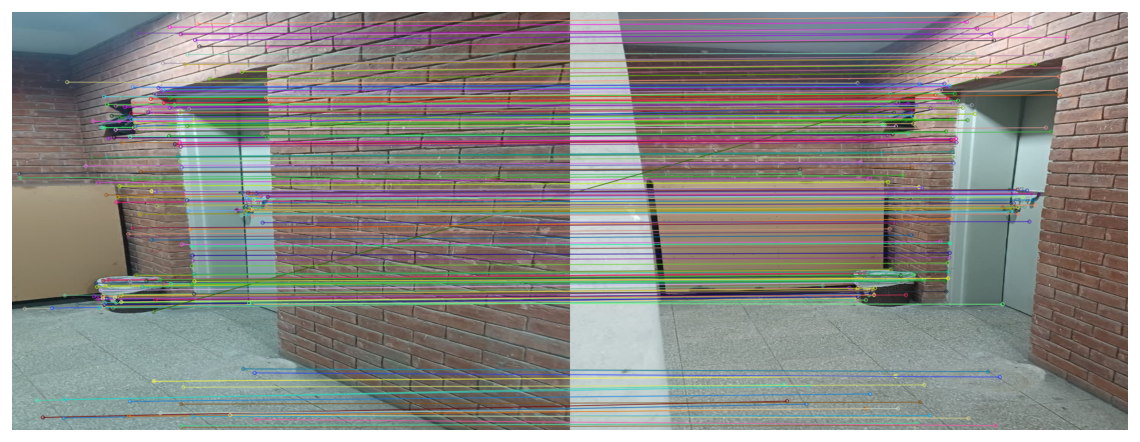

Saved match visualization to ./match_vis\matches_pair.png
Intrinsic K:
 [[1.024e+03 0.000e+00 5.120e+02]
 [0.000e+00 1.024e+03 3.840e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
Inliers after E/F estimation: 254
recoverPose returned: 254 inliers (pose): 64770
After geometric filtering: pts= 254 median reproj= 0.20998114192709094 median parallax= 21.000362122155817
Saved PLY: pointcloud_week2.ply
Done. Saved pointcloud_week2.ply

Estimated pose (R):
 [[ 0.96900282 -0.03056299  0.24515185]
 [ 0.02801575  0.99951123  0.01387185]
 [-0.24545599 -0.00657375  0.96938545]]

Estimated pose (t):
 [[ 0.98902904]
 [-0.12770227]
 [-0.07425428]]

Intrinsic K used:
 [[1.024e+03 0.000e+00 5.120e+02]
 [0.000e+00 1.024e+03 3.840e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
Done. Saved pointcloud_week2.ply

Estimated pose (R):
 [[ 0.96900282 -0.03056299  0.24515185]
 [ 0.02801575  0.99951123  0.01387185]
 [-0.24545599 -0.00657375  0.96938545]]

Estimated pose (t):
 [[ 0.98902904]
 [-0.12770227]
 [-0.07425428]]

Intr

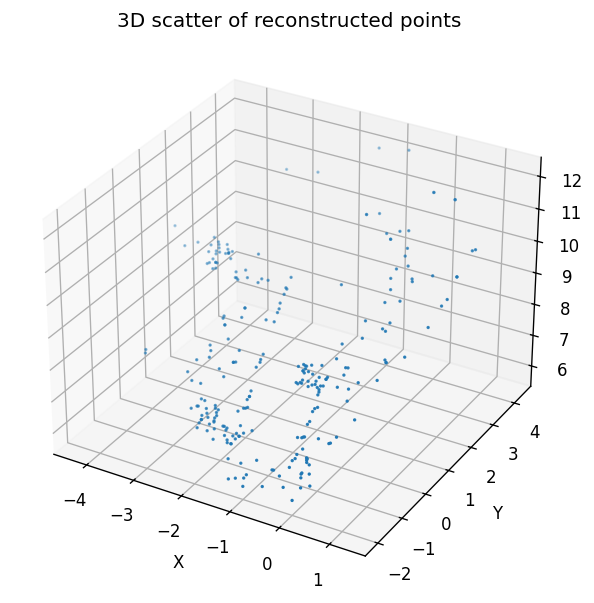

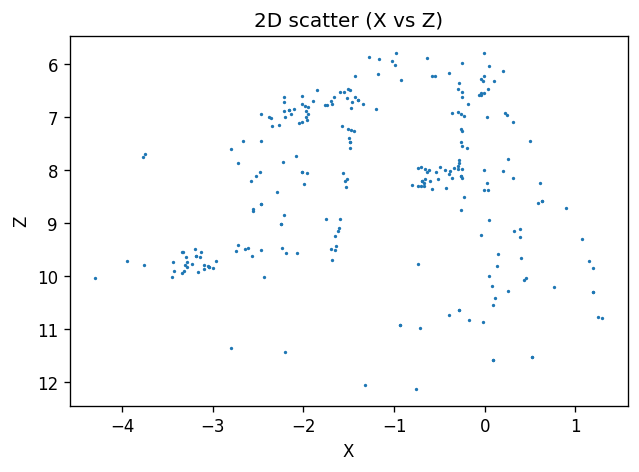

In [4]:
# EDIT THESE PATHS / INDICES as needed
images_folder = r'D:\lums\JUNIORFALL\CV\PROJECT\Dataset'
# Set idx0, idx1 to None to let the auto-scan pick a good pair
idx0, idx1 = None, None
out_ply = 'pointcloud_week2.ply'

imgs, files = load_images_from_folder(images_folder)
if len(imgs) == 0:
    raise RuntimeError('No images found in folder: ' + images_folder)
print(f'Found {len(imgs)} images. Using:\n  0: {files[idx0] if idx0 is not None else "auto"}\n  1: {files[idx1] if idx1 is not None else "auto"}')

# Run the two-view pipeline
pts3d, pose, K = run_phase2_pair(images_folder, idx0=idx0, idx1=idx1, out_ply=out_ply)
print('\nEstimated pose (R):\n', pose[0])
print('\nEstimated pose (t):\n', pose[1])
print('\nIntrinsic K used:\n', K)

# Matplotlib 3D scatter
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts3d[:,0], pts3d[:,1], pts3d[:,2], s=1)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('3D scatter of reconstructed points')
plt.show()

# 2D scatter of 3D point cloud (common view: X vs Z)
plt.figure(figsize=(6,4))
plt.scatter(pts3d[:,0], pts3d[:,2], s=1)
plt.xlabel('X'); plt.ylabel('Z'); plt.title('2D scatter (X vs Z)')
plt.gca().invert_yaxis()
plt.show()